In [3]:
import pandas as pd
import numpy as np
from numpy.lib.format import open_memmap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

### Imports

### Generate Data

In [2]:
def initialize_sample_memmap_npy():
    ref = pd.read_csv('data/patient_timepoints.csv', dtype={'patient_id': str, 'timepoint': int})

    feature_cols = ref.columns[2:]
    # Scale data with Pareto scaling
    feat_df = ref[feature_cols].astype(float)
    feat_df = feat_df.div(np.sqrt(feat_df.std()), axis=1)
    feat_df = feat_df.div(feat_df.sum(axis=1), axis=0)

    # Replace NA's with 0
    feat_df = feat_df.fillna(0.0)

    # Build lookup on scaled vectors
    sample_dict = {
        (row['patient_id'].lstrip('0'), row['timepoint']): 
           feat_df.iloc[i].to_numpy(dtype=np.float32)
        for i, row in ref.iterrows()
    }

    for split in ('train','val','test'):
        pairs = pd.read_csv(f'data/{split}_pair_keys.csv',
                            dtype={'patient_id_a':str,'timepoint_a':int,
                                   'patient_id_b':str,'timepoint_b':int})
        n = len(pairs)
        feature_dim = len(feature_cols)

        X_mm = open_memmap(f'data/{split}_scaled_X.npy', mode='w+', dtype='float32',
                           shape=(n, feature_dim))
        y_mm = open_memmap(f'data/{split}_scaled_y.npy', mode='w+', dtype='int8',
                           shape=(n,))

        for i, row in enumerate(pairs.itertuples(index=False)):
            a, ta = row.patient_id_a.lstrip('0'), row.timepoint_a
            b, tb = row.patient_id_b.lstrip('0'), row.timepoint_b
            vec_a = sample_dict[(a, ta)]
            vec_b = sample_dict[(b, tb)]
            X_mm[i] = np.abs(vec_a - vec_b)
            y_mm[i] = 1 if a == b else 0

        X_mm.flush(); y_mm.flush()
        print(f"{split} data built: {X_mm.shape}")

initialize_sample_memmap_npy()

train data built: (26106, 40921)
val data built: (11935, 40921)
test data built: (8629, 40921)


### Load Data

In [3]:
# Load key files to get sizes and feature dimension
ref = pd.read_csv('data/patient_timepoints.csv', dtype={'patient_id':str,'timepoint':int})
feature_dim = ref.shape[1] - 2

train_pairs = pd.read_csv('data/train_pair_keys.csv', dtype={'patient_id_a':str,'timepoint_a':int,'patient_id_b':str,'timepoint_b':int})
val_pairs   = pd.read_csv('data/val_pair_keys.csv',   dtype=train_pairs.dtypes.to_dict())
test_pairs  = pd.read_csv('data/test_pair_keys.csv',  dtype=train_pairs.dtypes.to_dict())

n_train = len(train_pairs)
n_val   = len(val_pairs)
n_test  = len(test_pairs)

# Memory-map the data
train_X = np.load('data/train_scaled_X.npy', mmap_mode='r')
train_y = np.load('data/train_scaled_y.npy', mmap_mode='r')
val_X   = np.load('data/val_scaled_X.npy',   mmap_mode='r')
val_y   = np.load('data/val_scaled_y.npy',   mmap_mode='r')
test_X  = np.load('data/test_scaled_X.npy',  mmap_mode='r')
test_y  = np.load('data/test_scaled_y.npy',  mmap_mode='r')

In [13]:
# count the number of positive and negative samples
pos_count = np.sum(train_y)
neg_count = n_train - pos_count
print(f"Train set: {n_train} samples, {pos_count} positives, {neg_count} negatives")

# validation set
val_pos_count = np.sum(val_y)
val_neg_count = n_val - val_pos_count
print(f"Validation set: {n_val} samples, {val_pos_count} positives, {val_neg_count} negatives")

# test set
test_pos_count = np.sum(test_y)
test_neg_count = n_test - test_pos_count
print(f"Test set: {n_test} samples, {test_pos_count} positives, {test_neg_count} negatives")

Train set: 26106 samples, 624 positives, 25482 negatives
Validation set: 11935 samples, 189 positives, 11746 negatives
Test set: 8629 samples, 111 positives, 8518 negatives


### Train Model

In [62]:
# Logistic Regression model
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10
)
classes    = np.unique(train_y)

# Mini‐batch training
# cross validation implemented with sklearn cross_val_score
from sklearn.model_selection import StratifiedKFold
negative_weight = 0.05
positive_weight = 2.0
print(f"Negative weight: {negative_weight:.4f}, Positive weight: {positive_weight:.4f}")
sample_weight = np.where(train_y == 1, positive_weight, negative_weight)
clf.fit(train_X, train_y, sample_weight=sample_weight)


for name, X, y in [('Train', train_X, train_y),
                  ('Val',   val_X,   val_y),
                  ('Test',  test_X,  test_y)]:
    pred = clf.predict(X)
    acc   = accuracy_score(y, pred)
    recall = np.sum((y == 1) & (pred == 1)) / np.sum(y == 1)
    precision = np.sum((y == 1) & (pred == 1)) / np.sum(pred == 1)
    fpr = np.sum((y == 0) & (pred == 1)) / np.sum(y == 0)
    f1    = f1_score(y, pred, average='weighted')
    print(f"{name:5} → Acc: {acc:.4f}, F1: {f1:.4f}, recall: {recall:.4f}, precision: {precision:.4f}, fpr: {fpr:.4f}")

Negative weight: 0.0500, Positive weight: 2.0000
Train → Acc: 0.9966, F1: 0.9967, recall: 1.0000, precision: 0.8739, fpr: 0.0035
Val   → Acc: 0.9994, F1: 0.9994, recall: 0.9630, precision: 1.0000, fpr: 0.0000
Test  → Acc: 0.9947, F1: 0.9951, recall: 0.9910, precision: 0.7097, fpr: 0.0053


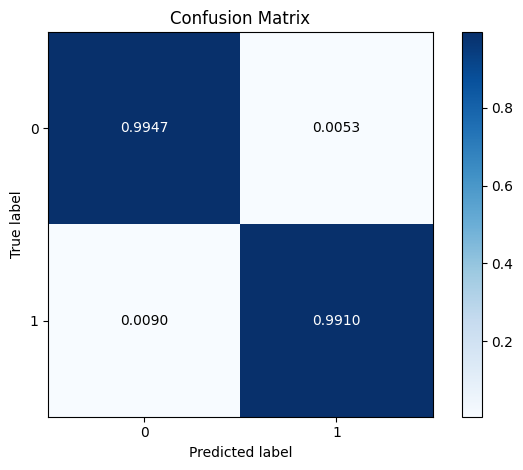

In [66]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches       


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm = cm.astype('int')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')
    fig.colorbar(im)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax.text(j, i, f'{cm[i, j]:.4f}', ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.show()
plot_confusion_matrix(test_y, pred, classes=classes, normalize=True)

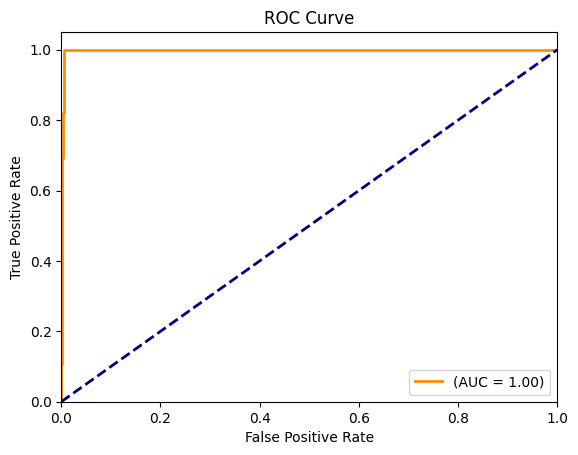

In [72]:
# plot AUC ROC curve
from sklearn.metrics import roc_curve, auc

y_pred_prob = clf.predict_proba(test_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='(AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Inspect features

In [64]:
# View top peptidoform features
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(feature_dim)[:20]:
    print(f"Features {indices[f]:2d}:  {importances[indices[f]]:.4f}")

Feature ranking:
Features 116:  0.0138
Features 2348:  0.0112
Features 340:  0.0108
Features 1232:  0.0094
Features 4748:  0.0084
Features 1704:  0.0084
Features 3052:  0.0080
Features 1251:  0.0080
Features 23:  0.0074
Features 3600:  0.0072
Features 1633:  0.0072
Features 1521:  0.0071
Features 1049:  0.0070
Features 27:  0.0070
Features 1573:  0.0068
Features 2640:  0.0067
Features 2561:  0.0066
Features 1694:  0.0063
Features 810:  0.0062
Features 1274:  0.0062


In [4]:
# check the correlation of the features with the target
# check the correlation of the features with the target from y_train, y_val, y_test

train_X_df = pd.DataFrame(train_X[:, [116, 2348, 340, 1232, 4748, 1704, 3052, 1251, 23, 3600]])
train_y_df = pd.DataFrame(train_y, columns=['target'])
train_df = pd.concat([train_X_df, train_y_df], axis=1)
corr = train_df.corr()

In [5]:
corr

,0,1,2,3,4,5,6,7,8,9,target
0,1.000000,0.089943,0.026608,-0.005702,0.058556,0.108322,0.074413,0.037933,0.074280,0.070530,-0.164344
1,0.089943,1.000000,0.063948,0.088273,-0.030820,0.056165,0.283416,0.026412,-0.031105,0.047553,-0.102810
2,0.026608,0.063948,1.000000,0.119235,-0.015827,0.045524,0.073952,0.014802,-0.016688,-0.009047,-0.169123
3,-0.005702,0.088273,0.119235,1.000000,0.005345,0.000698,0.031721,0.018094,-0.051651,-0.026979,-0.158404
4,0.058556,-0.030820,-0.015827,0.005345,1.000000,0.032487,0.027845,0.003646,-0.050438,0.009859,-0.133582
5,0.108322,0.056165,0.045524,0.000698,0.032487,1.000000,0.111271,0.021020,0.101797,0.041547,-0.170121
6,0.074413,0.283416,0.073952,0.031721,0.027845,0.111271,1.000000,-0.024752,-0.063256,0.126046,-0.135308
7,0.037933,0.026412,0.014802,0.018094,0.003646,0.021020,-0.024752,1.000000,-0.015189,-0.024251,-0.142192
8,0.074280,-0.031105,-0.016688,-0.051651,-0.050438,0.101797,-0.063256,-0.015189,1.000000,-0.065726,-0.086588
9,0.070530,0.047553,-0.009047,-0.026979,0.009859,0.041547,0.126046,-0.024251,-0.065726,1.000000,-0.139867


In [73]:
# show the peptidoform features
df = pd.read_csv('data/filtered_results.tsv', sep='\t')
df.iloc[indices[:20], :].to_csv('data/top_peptidoform_features.tsv', sep='\t', index=False)

/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_36978/1758957761.py:2: DtypeWarning: Columns (40,44,46,50,54,58,94,100,104,110,118,124,126,128,130,132,134,136,140,142,146,148,150,152,154,156,158,178,186,192,198,202,214,218,230,236,238,240,244,246,248,250,252,254,256,258,260,262,264,266,270,272,274,276,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,320,324,326,332,334,336,338,340,342,344,346,348,352,366,374,376,380,382,384,390,392,394,396,400,406,408,410,412,414,416,418,428,430,442,446,448,456,460,462,466,468,470,486,504,512,516,518,524,526,528,530,540,542,544,546,554,556,558,560,564,578,594,608,610,612,614,620,624,626,628,630,632,634,642,644,646,648,652,654,656,658,660,662,664,666,676,678,680,686,688,694,696,698,700,702,704) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/filtered_results.tsv', sep='\t')
